In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from collections import Counter 

from sklearn.model_selection import train_test_split
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models
from torchinfo import summary

from tqdm import tqdm
import timm

from datetime import datetime

Let's load the different bird species from the `class_names.npy` file and then the attributes from `attributes.npy` which has for every class 312 features that are explained by the file `attributes.txt`.

In [2]:
images_df = pd.read_csv("data/train_images.csv")
images_df["image_path"] = images_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
images_df.head()

,image_path,label
0,data/train_images/1.jpg,1
1,data/train_images/2.jpg,1
2,data/train_images/3.jpg,1
3,data/train_images/4.jpg,1
4,data/train_images/5.jpg,1


In [34]:
train_img_dir = 'data/train_images/'
image_sizes = []
error_count = 0
for root, _, files in os.walk(train_img_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")
                    width, height = img.size
                    image_sizes.append((width, height))
            except Exception as e:
                print(f"Error: {e}")
                error_count += 1
                
biggest = max(image_sizes, key=lambda x: x[0]*x[1])
smallest = min(image_sizes, key=lambda x: x[0]*x[1])

size_counts = Counter(image_sizes)
most_common_size, count = size_counts.most_common(1)[0]

print("Biggest image:", biggest)
print("Smallest image:", smallest)
print(f"Most common dimensions: {most_common_size}")

Biggest image: (500, 500)
Smallest image: (150, 150)
Most common dimensions: (500, 333)


In [35]:
attributes = np.load('data/attributes.npy')
attributes.shape

(200, 312)

### Define Device (GPU or CPU)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Class imbalance

To mitigate class imbalance, each training sample is assigned a weight inversely proportional to the frequency of its class. 
These weights are then mapped to individual samples and used during training (e.g., via a weighted sampler) to increase the sampling probability of underrepresented classes.

In [37]:
label_counts = images_df['label'].value_counts()
num_samples = len(images_df)

class_weights = {cls: num_samples / count for cls, count in label_counts.items()}
sample_weights = images_df['label'].map(class_weights).values

In [12]:
# to handle the imbalance in data
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True)

### Load training metadata and create train/validation split
We create a stratified train/validation split so that all 200 classes are represented proportionally in both sets.  
This split will be used to train the CNN on `train_images` and evaluate it on `val_images`.

In [38]:
train_images, val_images = train_test_split(
    images_df,
    test_size=0.1,
    stratify=images_df["label"],
    random_state=42)
len(train_images), len(val_images)

(3533, 393)

In [39]:
train_images.head()

,image_path,label
1706,data/train_images/1707.jpg,59
552,data/train_images/553.jpg,19
2422,data/train_images/2423.jpg,88
3590,data/train_images/3591.jpg,159
1105,data/train_images/1106.jpg,37


### Create a custom PyTorch Dataset for bird images

Here we define a `BirdsDataset` class that:
- Reads the image path and label from the DataFrame rows.
- Loads each image with PIL.
- Applies the appropriate transform (train or validation).
- Converts labels from 1–200 to 0–199 so they work with `nn.CrossEntropyLoss`.

This Dataset will be used together with a DataLoader to efficiently feed batches to the CNN.

In [40]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None, use_attributes=False, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.use_attributes = use_attributes
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img
        else:
            label = int(row["label"]) - 1  # for training set also return the label in 0-199
            return img, label

### Wrap Datasets in DataLoaders

Now we create `DataLoader` objects for the training and validation sets.  
DataLoaders handle:
- Shuffling (for training),
- Batching,
- Parallel loading of images (with `num_workers`).

These will be used directly in the training and evaluation loops.


#### Different seed for each run to test accuracy for the model on different data

In [41]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Makes cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Define Loaders

In [42]:
def define_loaders(train_images, val_images, device, batch_size, generator):

    train_dataset = BirdsDataset(train_images, transform=train_transform)
    val_dataset = BirdsDataset(val_images, transform=val_transform)
    
    if device == 'cpu': 
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
           # sampler = sampler, # if use set shuffle = False
            shuffle=True,  # model sees data in random order
            generator=generator,
            num_workers=0, # parallel processing
            pin_memory=True # faster data transfer to GPU
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,  # model sees data in random order
            num_workers=4, # parallel processing
            pin_memory=True # faster data transfer to GPU
        )
    
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    return train_loader, val_loader

### EarlyStopping Callback

The `EarlyStopping` class is a training utility that monitors validation loss and stops training when the model stops improving.  
This helps prevent **overfitting** and saves training time.

#### How it works
- **patience**: How many epochs to wait for improvement before stopping.
- **min_delta**: Minimum decrease in validation loss that counts as an improvement.
- **best_score**: Tracks the best (lowest) validation loss seen so far.
- **counter**: Counts how many consecutive epochs had no improvement.
- **early_stop**: Becomes `True` when early stopping should trigger.

#### When validation loss does *not* improve:
- The counter increases.
- If the counter reaches `patience`, training will stop early.

This class is typically used during training loops to prevent unnecessary epochs once the model stops learning.

In [43]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self._update(val_loss)

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self._update(val_loss)
            self.counter = 0

    def _update(self, val_loss):
        if self.verbose:
            print(
                f'Validation loss decreased '
                f'({self.val_loss_min:.6f} → {val_loss:.6f}).'
            )
        self.val_loss_min = val_loss

### To plot training vs accuracy per epoch

In [44]:
def train_val_plot(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Initialize Test Dataset

In [45]:
def initialize_test_dataset(test_path, test_transform): 
    test_df = pd.read_csv(test_path)
    test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
    
    test_dataset = BirdsDataset(test_df, transform=test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    return test_loader

#### Initialize predictions and cnn_models folder

In [46]:
os.makedirs("predictions", exist_ok=True)
os.makedirs("cnn_models", exist_ok=True)

## Our current best CNN Architecture

## Approach: Replicate ResNet and use attributes

In [47]:
# Basic Residual Block used in ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection if dimensions change
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# ResNet-18 CNN architecture
class ResNet18CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64

        # Initial convolution + BN + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

    def _make_layer(self, out_channels, blocks, stride):
        layers = [BasicBlock(self.in_channels, out_channels, stride)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x  # Output feature maps

In [48]:
class ResNet18AttrMultiTask(nn.Module):
    def __init__(self, class_attributes, feat_dim=512, scale=10.0):
        super().__init__()
        self.num_classes = class_attributes.shape[0]
        self.attr_dim = class_attributes.shape[1]
        self.scale = scale

        # CNN backbone
        self.cnn = ResNet18CNN()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Project CNN features to attribute space
        self.attr_proj = nn.Linear(feat_dim, self.attr_dim, bias=False)
        self.dropout = nn.Dropout(p=0.3)

        # Learnable class embeddings
        self.class_embeddings = nn.Parameter(class_attributes.clone())

    def forward(self, x):
        features = self.cnn(x)
        features = self.avgpool(features)
        features = torch.flatten(features, 1)  # (batch, feat_dim)
        features = self.dropout(features)

        # Project to attribute space
        attr_pred = self.attr_proj(features)  # (batch, attr_dim)

        # Cosine similarity classifier
        x_norm = F.normalize(attr_pred, p=2, dim=1)
        class_norm = F.normalize(self.class_embeddings, p=2, dim=1)
        logits = self.scale * torch.matmul(x_norm, class_norm.t())  # (batch, num_classes)

        return logits, attr_pred

1. Extracts deep features from the image using ResNet-18.

2. Projects features to attribute space (learned 312-dim vector).

3. Computes cosine similarity between image embedding and learnable class embeddings → predicts class.

4. Returns both class logits and predicted attributes, so you can do multi-task learning:

5. CrossEntropyLoss(logits, labels) → main supervised classification loss

6. MSELoss(attr_pred, true_attributes) → auxiliary attribute reconstruction loss

In [49]:
def multi_task_train_one_epoch(model, train_loader, optimizer, device, class_attributes, criterion_cls, criterion_attr, alpha):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward
        logits, attr_pred = model(images)

        # Losses
        loss_cls = criterion_cls(logits, labels)
        true_attrs = class_attributes[labels].to(device)
        loss_attr = criterion_attr(attr_pred, true_attrs)

        loss = loss_cls + alpha * loss_attr
        loss.backward()
        optimizer.step()

        # Metrics
        batch_size = labels.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_samples += batch_size

    return (total_loss / total_samples, total_correct / total_samples)

In [50]:
def multi_task_evaluate(model, dataloader, device, class_attributes, criterion_cls, criterion_attr, alpha):
    model.eval()

    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits, attr_pred = model(images)

            # Losses
            loss_cls = criterion_cls(logits, labels)
            true_attrs = class_attributes[labels].to(device)
            loss_attr = criterion_attr(attr_pred, true_attrs)

            loss = loss_cls + alpha * loss_attr

            # Metrics
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_correct += (logits.argmax(1) == labels).sum().item()
            total_samples += batch_size

    return (total_loss / total_samples, total_correct / total_samples)

In [51]:
def multi_task_train_model(model, model_path, class_attributes, optimizer, 
    alpha=0.01,
    scheduler=None,
    batch_size = 64,
    early_stopping_patience=10,
    num_epochs=300):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # same dataset for all the runs (and same shuffle)
    g = torch.Generator()
    g.manual_seed(45)
    set_seed(43)
    train_loader, val_loader = define_loaders(train_images, val_images, device, batch_size, generator=g)
    

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.0, verbose=True)

    model.to(device)

    num_params = sum(p.numel() for p in model.parameters())
    print('Total parameters:', num_params)
    
    # Prepare loss functions
    criterion_cls = nn.CrossEntropyLoss()
    criterion_attr = nn.MSELoss()

    best_val_acc = 0.0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        train_loss, train_acc = multi_task_train_one_epoch(model, train_loader, optimizer, device, class_attributes, criterion_cls, criterion_attr, alpha)

        val_loss, val_acc = multi_task_evaluate(model, val_loader, device, class_attributes, criterion_cls, criterion_attr, alpha)

        # Logging
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f" Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
        print(f" Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Scheduler step
        if scheduler:
            scheduler.step(val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"✔ Saved new best model (val_acc={best_val_acc:.4f})")

        # early stopping on val_loss
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print('Best Validation accuracy:', best_val_acc)
    train_val_plot(train_losses, val_losses, train_accs, val_accs)
    
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_val_acc": best_val_acc,
    }

In [52]:
# preprocessing and augmentation
train_transform = T.Compose([
    T.Resize((384,384)),
    T.RandomResizedCrop(336, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(0.4,0.4,0.4,0.1),
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.5, scale=(0.02, 0.33))
])

val_transform = T.Compose([
    T.Resize((384, 384)),       # same initial resize
    T.CenterCrop(336),          # same final spatial size as training
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
class_attributes = torch.tensor(attributes, dtype=torch.float32).to(device) # (200, 312)
scale=15
model = ResNet18AttrMultiTask(class_attributes, scale=scale).to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # STRICTLY BETTER

batch_size = 64
alpha=0.4 # current optimal 0.4

# scheduler: reduce LR when val_loss plateaus
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# CAREFUL TO NOT OVERWRITE
model_name = "1.20architecture_resnet18_attributes.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

In [26]:
results = multi_task_train_model(
    model=model,
    model_path=model_path,
    class_attributes=class_attributes,
    optimizer=optimizer,
    alpha=alpha,
    scheduler=scheduler,
    batch_size=batch_size)

### Prediction

In [42]:
def multi_task_prediction(test_df, model, model_name, test_loader, test_path):
    all_preds = []

    model.eval()
    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
            
            # Multi-task model returns (logits, attr_pred)
            logits, _ = model(images)  

            preds = torch.argmax(logits, 1)  # 0–199
            preds = preds.cpu().numpy() + 1  # 1–200 (CUB format)
            all_preds.extend(preds)
            
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_path = f"predictions/{model_name}_{timestamp}.csv"

    test_df["label"] = all_preds
    test_df[["id", "label"]].to_csv(file_path, index=False)

    print(f"Saved predictions to {file_path}")

In [43]:
# initialize model
model = ResNet18AttrMultiTask(class_attributes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
multi_task_prediction(test_df, model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:04<00:00, 15.06it/s]

Saved predictions to predictions/1.19architecture_resnet18_attributes.pt_2025-12-14_02-10.csv


### Best model results

Best Validation accuracy: 0.43256997455470736


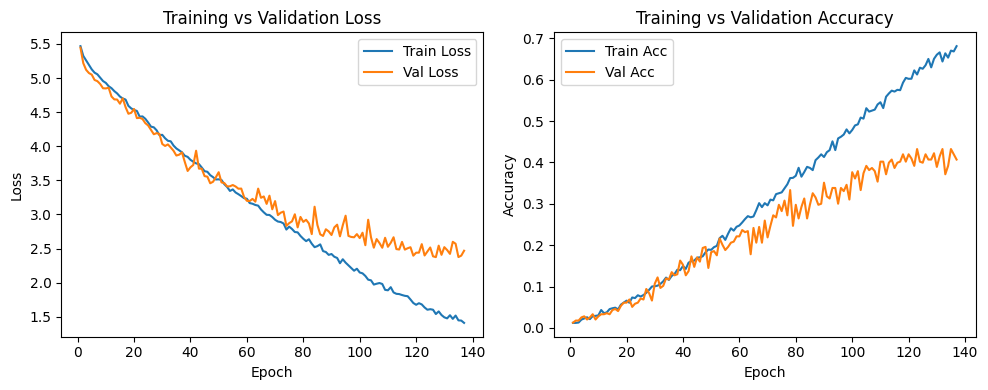

In [44]:
train_losses = results['train_losses']
val_losses = results['val_losses']
train_accs = results['train_accs']
val_accs = results['val_accs']
best_val_acc = results['best_val_acc']

print('Best Validation accuracy:', best_val_acc)
train_val_plot(train_losses, val_losses, train_accs, val_accs)

In [61]:
# predict a sample image

model = ResNet18AttrMultiTask(class_attributes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

with torch.no_grad():
    images = next(iter(test_loader))
    images = images.to(device)

    logits, attr_pred = model(images)

    first_logits = logits[0]            # (num_classes,)
    first_pred = torch.argmax(first_logits).item() + 1  # 1–200

print("Predicted class:", first_pred)
print("Logits shape:", first_logits.shape)
print("Top-5 logits:", torch.topk(first_logits, 5))


Predicted class: 67
Logits shape: torch.Size([200])
Top-5 logits: torch.return_types.topk(
values=tensor([5.8968, 5.1026, 4.8370, 4.7991, 4.4417], device='cuda:0'),
indices=tensor([66, 69, 38, 68, 67], device='cuda:0'))


## Comparison with a pretrained model

### ResNet18

As a strong baseline, we use a pretrained `ResNet18` from `torchvision.models`:
- We load ImageNet-pretrained weights.
- We replace the final fully-connected layer so it outputs 200 logits (one per bird class).
- The rest of the network acts as a feature extractor.

This gives a solid starting point for accuracy without heavy custom architecture work.


In [55]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [56]:
# Load pretrained ResNet18
weights = models.ResNet18_Weights.IMAGENET1K_V1
ResNet_model = models.resnet18(weights=weights)

# Replace the final layer to match 200 classes
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)

ResNet_model = ResNet_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
ResNet_optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=1e-4)

In [58]:
baseline_model_dir = "cnn_models"
baseline_model_path = os.path.join(baseline_model_dir, model_name)
baseline_model_name = "best_resnet18.pt"

early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 100
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# same dataset for all the runs (and same shuffle)
g = torch.Generator()
g.manual_seed(45)
set_seed(43)
train_loader, val_loader = define_loaders(train_images, val_images, device, batch_size, generator=g)

num_params = sum(p.numel() for p in ResNet_model.parameters())
print('Total parameters:', num_params)

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}") 

    train_loss, train_acc = train_one_epoch(ResNet_model, train_loader, ResNet_optimizer, criterion, device)

    # ---- validation ----
    val_loss, val_acc = evaluate(ResNet_model, val_loader, criterion, device)

    # ---- logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    # ---- early stopping ----
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # ---- best model saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ResNet_model.state_dict(), baseline_model_path)
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")


Epoch 1/60


Validation loss decreased (inf → 4.547420).
  Train | loss: 5.1399, acc: 0.0362
  Val   | loss: 4.5474, acc: 0.1145
New best model saved with val_acc = 0.1145

Epoch 2/60


Validation loss decreased (4.547420 → 3.887105).
  Train | loss: 4.3980, acc: 0.1585
  Val   | loss: 3.8871, acc: 0.2443
New best model saved with val_acc = 0.2443

Epoch 3/60


Validation loss decreased (3.887105 → 3.502863).
  Train | loss: 3.9067, acc: 0.2482
  Val   | loss: 3.5029, acc: 0.3232
New best model saved with val_acc = 0.3232

Epoch 4/60


Validation loss decreased (3.502863 → 3.130623).
  Train | loss: 3.5271, acc: 0.3289
  Val   | loss: 3.1306, acc: 0.3868
New best model saved with val_acc = 0.3868

Epoch 5/60


Validation loss decreased (3.130623 → 2.909347).
  Train | loss: 3.2133, acc: 0.4028
  Val   | loss: 2.9093, acc: 0.4351
New best model saved with val_acc = 0.4351

Epoch 6/60


Validation loss decreased (2.909347 → 2.614012).
  Train | loss: 2.9062, acc: 0.4633
  Val   | loss: 2.6140, acc: 0.4529
New best model saved with val_acc = 0.4529

Epoch 7/60


Validation loss decreased (2.614012 → 2.556706).
  Train | loss: 2.6615, acc: 0.5075
  Val   | loss: 2.5567, acc: 0.4784
New best model saved with val_acc = 0.4784

Epoch 8/60


Validation loss decreased (2.556706 → 2.255437).
  Train | loss: 2.4336, acc: 0.5582
  Val   | loss: 2.2554, acc: 0.4885
New best model saved with val_acc = 0.4885

Epoch 9/60


Validation loss decreased (2.255437 → 2.105136).
  Train | loss: 2.2283, acc: 0.5856
  Val   | loss: 2.1051, acc: 0.5369
New best model saved with val_acc = 0.5369

Epoch 10/60


Validation loss decreased (2.105136 → 2.077297).
  Train | loss: 2.0534, acc: 0.6219
  Val   | loss: 2.0773, acc: 0.5267

Epoch 11/60


Validation loss decreased (2.077297 → 1.971814).
  Train | loss: 1.8751, acc: 0.6736
  Val   | loss: 1.9718, acc: 0.5700
New best model saved with val_acc = 0.5700

Epoch 12/60


Validation loss decreased (1.971814 → 1.895172).
  Train | loss: 1.7344, acc: 0.6988
  Val   | loss: 1.8952, acc: 0.5852
New best model saved with val_acc = 0.5852

Epoch 13/60


Validation loss decreased (1.895172 → 1.884687).
  Train | loss: 1.6088, acc: 0.7158
  Val   | loss: 1.8847, acc: 0.5522

Epoch 14/60


Validation loss decreased (1.884687 → 1.773147).
  Train | loss: 1.4910, acc: 0.7390
  Val   | loss: 1.7731, acc: 0.5776

Epoch 15/60


EarlyStopping counter: 1/5
  Train | loss: 1.3933, acc: 0.7603
  Val   | loss: 1.7749, acc: 0.5954
New best model saved with val_acc = 0.5954

Epoch 16/60


Validation loss decreased (1.773147 → 1.618130).
  Train | loss: 1.2770, acc: 0.7908
  Val   | loss: 1.6181, acc: 0.6336
New best model saved with val_acc = 0.6336

Epoch 17/60


Validation loss decreased (1.618130 → 1.560981).
  Train | loss: 1.1800, acc: 0.8160
  Val   | loss: 1.5610, acc: 0.6260

Epoch 18/60


EarlyStopping counter: 1/5
  Train | loss: 1.0889, acc: 0.8299
  Val   | loss: 1.6235, acc: 0.6285

Epoch 19/60


Validation loss decreased (1.560981 → 1.536081).
  Train | loss: 1.0306, acc: 0.8421
  Val   | loss: 1.5361, acc: 0.6361
New best model saved with val_acc = 0.6361

Epoch 20/60


EarlyStopping counter: 1/5
  Train | loss: 0.9518, acc: 0.8579
  Val   | loss: 1.6010, acc: 0.6260

Epoch 21/60


Validation loss decreased (1.536081 → 1.528150).
  Train | loss: 0.8780, acc: 0.8738
  Val   | loss: 1.5282, acc: 0.6514
New best model saved with val_acc = 0.6514

Epoch 22/60


Validation loss decreased (1.528150 → 1.484384).
  Train | loss: 0.8309, acc: 0.8760
  Val   | loss: 1.4844, acc: 0.6438

Epoch 23/60


EarlyStopping counter: 1/5
  Train | loss: 0.7526, acc: 0.8913
  Val   | loss: 1.5558, acc: 0.5954

Epoch 24/60


Validation loss decreased (1.484384 → 1.443683).
  Train | loss: 0.7522, acc: 0.8902
  Val   | loss: 1.4437, acc: 0.6438

Epoch 25/60


EarlyStopping counter: 1/5
  Train | loss: 0.6787, acc: 0.9026
  Val   | loss: 1.4895, acc: 0.6692
New best model saved with val_acc = 0.6692

Epoch 26/60


Validation loss decreased (1.443683 → 1.438729).
  Train | loss: 0.6280, acc: 0.9106
  Val   | loss: 1.4387, acc: 0.6667

Epoch 27/60


Validation loss decreased (1.438729 → 1.433938).
  Train | loss: 0.5732, acc: 0.9253
  Val   | loss: 1.4339, acc: 0.6412

Epoch 28/60


EarlyStopping counter: 1/5
  Train | loss: 0.5764, acc: 0.9205
  Val   | loss: 1.4510, acc: 0.6489

Epoch 29/60


Validation loss decreased (1.433938 → 1.414671).
  Train | loss: 0.5237, acc: 0.9239
  Val   | loss: 1.4147, acc: 0.6641

Epoch 30/60


EarlyStopping counter: 1/5
  Train | loss: 0.4969, acc: 0.9309
  Val   | loss: 1.4462, acc: 0.6667

Epoch 31/60


EarlyStopping counter: 2/5
  Train | loss: 0.5031, acc: 0.9264
  Val   | loss: 1.4484, acc: 0.6667

Epoch 32/60


EarlyStopping counter: 3/5
  Train | loss: 0.4501, acc: 0.9326
  Val   | loss: 1.4920, acc: 0.6412

Epoch 33/60


Validation loss decreased (1.414671 → 1.407534).
  Train | loss: 0.4391, acc: 0.9417
  Val   | loss: 1.4075, acc: 0.6463

Epoch 34/60


EarlyStopping counter: 1/5
  Train | loss: 0.4027, acc: 0.9423
  Val   | loss: 1.4279, acc: 0.6412

Epoch 35/60


EarlyStopping counter: 2/5
  Train | loss: 0.3832, acc: 0.9474
  Val   | loss: 1.4277, acc: 0.6641

Epoch 36/60


EarlyStopping counter: 3/5
  Train | loss: 0.3658, acc: 0.9539
  Val   | loss: 1.4188, acc: 0.6489

Epoch 37/60


EarlyStopping counter: 4/5
  Train | loss: 0.3630, acc: 0.9459
  Val   | loss: 1.4340, acc: 0.6667

Epoch 38/60


EarlyStopping counter: 5/5
Early stopping triggered!


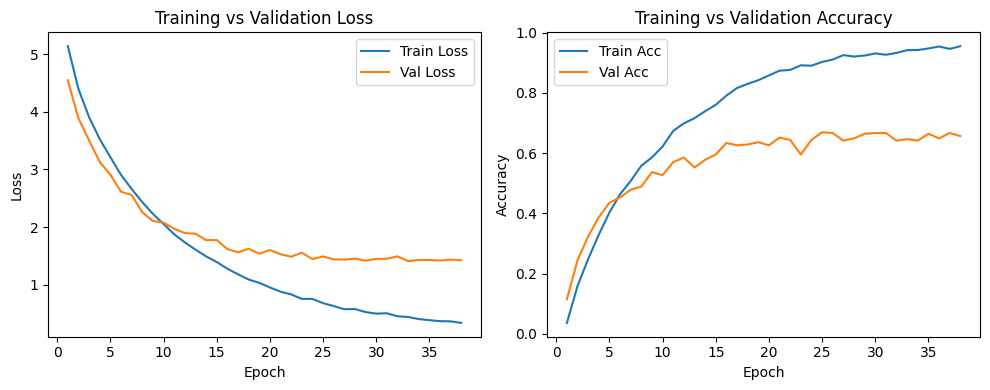

In [59]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

In [60]:
ResNet_model = models.resnet18()
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)
ResNet_model.load_state_dict(torch.load(baseline_model_path, map_location=device))
ResNet_model = ResNet_model.to(device)
ResNet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
def prediction(test_df, model, model_name, test_loader, test_path):
    all_preds = []
    
    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
    
            logits = model(images)          # (B, 200)
            preds = torch.argmax(logits, 1) # 0–199
    
            preds = preds.cpu().numpy() + 1 # 1–200 (CUB format)
            all_preds.extend(preds)
            
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_path = f"predictions/{model_name}_{timestamp}.csv"
    
    test_df["label"] = all_preds
    test_df[["id", "label"]].to_csv(file_path, index=False)
    
    print(f"Saved predictions to {file_path}")

In [62]:
test_dataset_path = "data/test_images_path.csv"
test_df = pd.read_csv(test_dataset_path)
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(test_df, ResNet_model, baseline_model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:04<00:00, 15.04it/s]

Saved predictions to predictions/best_resnet18.pt_2025-12-14_14-35.csv
